# Importing Necessary Libraries

In [33]:
import warnings, os, xlrd, pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn import linear_model, preprocessing
 
%matplotlib inline
warnings.filterwarnings('ignore')

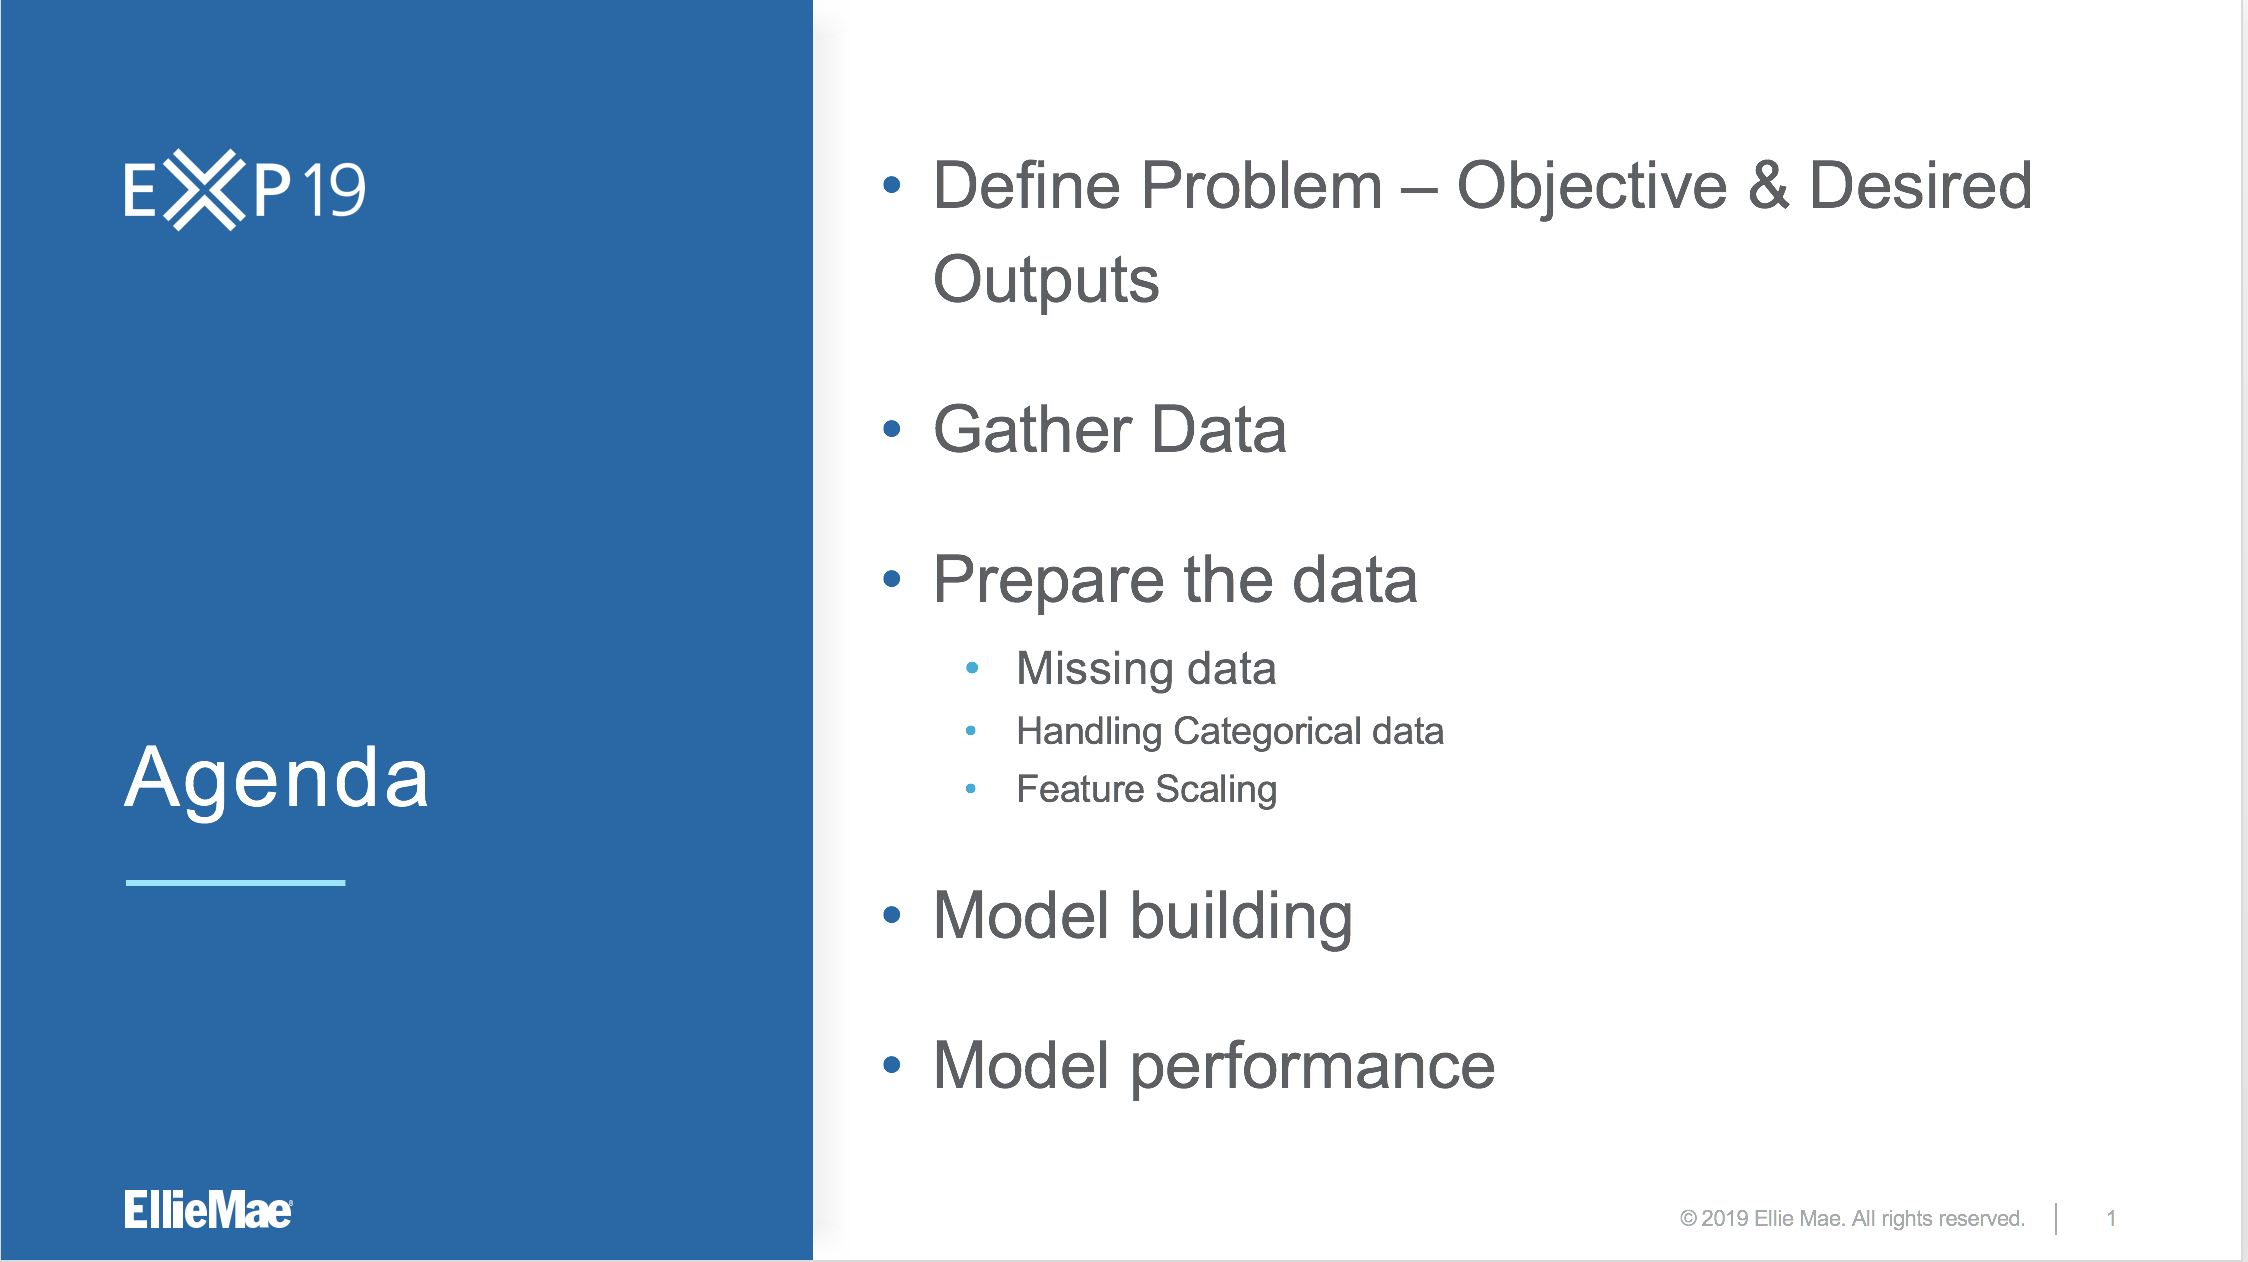

In [22]:
from IPython.display import Image
Image(filename='NotebookAgenda.png', width=900, height=700)

# Objective and Desired Outputs
#     
### **Objective**: We want to predict whether a loan will be closed or not.
###       
### **Desired Outputs**: Given the features of a loan, predict whether it's going to be closed or not.
###       

# Gather Data
#### Data gathering is the first real step towards the success of a machine learning model. The quality of data will cascade in how good the model will be. 

(We collected data from several of our customers, where the loans were from in 2016. The numerical features are slightly modified to further ensure privacy.)

In [32]:
raw_data = pd.read_csv('EXP_Data_DataScience.csv').drop(['Unnamed: 0'], axis=1)
closed_loans = raw_data.ix[raw_data['LoanStatus'] == 'Closed',:]
non_closed_loans = raw_data.ix[raw_data['LoanStatus'] == 'Not_Closed',:]

# To see some basic statistics of the data, e.g. mean, STD, etc. 
raw_data.describe()
# To see the first 5 rows of the data
raw_data.head()

LoanType                     FHA
LoanPurpose             Purchase
AmortizationType           Fixed
LTV                           97
FICO                         749
DTI                           37
LoanAmount                112905
AppraisedValue            117000
EstimatedValue            117000
Fixed                          1
APR                            0
NoteRate                       4
TermInYears                   30
LoanStatus                Closed
PropertyState                 IN
PropertyZip                46113
MSA                        26900
AgeBucket           Generation X
income                   4473.73
Name: 0, dtype: object

In [24]:
print('  The number of closed and not closed loans:')
print('  Closed Loans: {}, Not-Closed Loans: {}'.format(len(closed_loans), len(non_closed_loans)))

n = 10634
non_closed_loans = pd.concat([non_closed_loans, \
                              non_closed_loans.iloc[np.random.randint(len(non_closed_loans), \
                                                                      size=n)]])
print('  There is an inbalance of data points between two groups, \n \
 so we artificially populate not closed loans through over-sampling. \n \
 After this procedure, there will be {} closed loans, and {} not-closed loans.'\
      .format(len(closed_loans), len(non_closed_loans)))

# Now combine closed and non_closed loans by concatenating 
# the closed/non-closed loans into one dataframe
combined_dataframe = pd.concat([non_closed_loans, closed_loans])

# Reset index and then shuffle the data
combined_dataframe = combined_dataframe.copy().reset_index(drop=True)
combined_dataframe = combined_dataframe.sample(frac=1).reset_index(drop=True)

  The number of closed and not closed loans:
  Closed Loans: 60000, Not-Closed Loans: 9366
  There is an inbalance of data points between two groups, 
  so we artificially populate not closed loans through over-sampling. 
  After this procedure, there will be 60000 closed loans, and 20000 not-closed loans.


# Preparing The Data
####   
#### Before begining to train models we should transform our data in a way that can be fed into a Machine Learning model. The most common techniques are:
####  
### **Dealing with missing data and outliers**
It is common to miss some values of data. It may be due to various reasons like errors on the data collection, measurements not applicable, etc. For the same reasons, there can be outliers with extreme values or values that doesn't make sense. For example, a FICO score of 851 is invalid but it will not be recognized by our model. 

Missing values are typically represented with the `NaN` or `Null`. The problem is that most algorithms can’t handle  missing values. Therefore, we need to take care of them before feeding data to our models. Once they are identified, there are several ways to deal with them:

1) Eliminating the samples or features with missing values/outliers. (we risk to lose relevant information or too many samples) **[We are using this method below]**

2) Populating the missing values/outliers with some other values. One common approach is to set them as the mean/median/mode value of the rest of the samples.

In [25]:
combined_dataframe = combined_dataframe.dropna(how='any').reset_index(drop=True)

### **Handling Caterogical Data**
When dealing with categorical data, we work with ordinal and nominal features. Ordinal features are categorical features that can be sorted (cloth’s size: L<M<S). While nominal features don’t imply any order (cloth’s color: yellow, green, red). The methods to deal with ordinal and nominal features are:

1) **Mapping ordinal features:** to make sure that the algorithm interprets the ordinal features correctly, we need to convert the categorical string values into integers. Frequently we will do this mapping manually. Example: L:2, M:1, S:0.

2) **Encoding nominal class labels:** The most common approach is to perform one-hot encoding, which consists in creating a new dummy feature for each unique value in the nominal feature column. Example: in the loan purpose column, if we have two classes: `Purchase` and `Refinance`, and perform one-hot encoding, we will get two new columns, one for each unique class. Then, if we have a Purchase loan, it will be sampled as: `Purchase` = 1, `Refinance` = 0. **[We are using this method below]**

In [26]:
combined_dataframe = combined_dataframe.join(pd.get_dummies(combined_dataframe['LoanType']))
combined_dataframe = combined_dataframe.drop(['LoanType'], axis=1)
combined_dataframe = combined_dataframe.rename(index=str, columns={"Other": "OtherLoanType"})
combined_dataframe = combined_dataframe.rename(index=str, columns={"VA": "VALoan"})

combined_dataframe = combined_dataframe.join(pd.get_dummies(combined_dataframe['LoanPurpose']))
combined_dataframe = combined_dataframe.drop(['LoanPurpose'], axis=1)
combined_dataframe = combined_dataframe.drop(['AmortizationType'], axis=1)
combined_dataframe = combined_dataframe.rename(index=str, columns={"Other": "OtherLoanPurpose"})

combined_dataframe = combined_dataframe.join(pd.get_dummies(combined_dataframe['AgeBucket']))
combined_dataframe = combined_dataframe.drop(['AgeBucket'], axis=1)

combined_dataframe = combined_dataframe.join(pd.get_dummies(combined_dataframe['PropertyState']))
combined_dataframe = combined_dataframe.drop(['PropertyState'], axis=1)

LABEL_COLUMN = 'LoanStatus'
combined_dataframe[LABEL_COLUMN] = (combined_dataframe[LABEL_COLUMN]\
                                    .apply(lambda x: x == 'Closed')).astype(int)

# **Feature Scaling**
This is a crucial step in the preprocessing phase as the majority of machine learning algorithms perform much better when dealing with features that are on the same scale. The most common techniques are:


1) **Normalization:** it refers to rescaling the features to a range of `[0,1]`. To normalize our data we’ll simply need to apply the min-max scaling method to each feature column.

$X_{new} = \frac{X - X_{min}}{X_{max} - X_{min}}$

2) **Standardization:** it consists in centering the feature columns to have mean ($\mu$) = 0 with standard deviation ($\sigma$) = 1 so that the feature columns have the same parameters as a standard Normal distribution. This makes it easier for model to learn. In addition, it keeps useful information about outliers and makes the algorithms less sensitive to them.

$z = \frac{x - \mu}{\sigma}$

$\mu$ = mean

$\sigma$ = standard deviation



In [35]:
combined_dataframe['DTI'] = preprocessing.scale(combined_dataframe['DTI'])

# Train/Test Data Split
### When traning/testing your model, you want to save a small portion of your data to test. Here we train on 80% of the data, randomly selected, and reserve remaining data to test the model performance. 

In [36]:
train, test = train_test_split(combined_dataframe, test_size = 0.2)
train, test = train.reset_index(), test.reset_index()
train, test = train.drop('index', axis=1), test.reset_index().drop(['index', 'level_0'], axis=1)

print('  train shape ={}, test shape={}'.format(train.shape, test.shape))

  train shape =(63464, 75), test shape=(15866, 75)


In [37]:
X = train.ix[:, train.columns != LABEL_COLUMN]
Y = train[LABEL_COLUMN]

logreg = linear_model.LogisticRegression(C=1e5)

logreg.fit(X, Y);
test_y = logreg.predict(test.ix[:, test.columns != LABEL_COLUMN])

# Below are a few different measurements of performance

In [38]:
print('  Accuracy is %.2f' %(np.sum(test_y == test[LABEL_COLUMN].values)/len(test)))

  Accuracy is 0.75


In [14]:
y_score = logreg.fit(X, Y).decision_function(test.ix[:, test.columns != LABEL_COLUMN])

fpr, tpr, _ = roc_curve(test[LABEL_COLUMN].ravel(), y_score.ravel())
roc_auc = auc(fpr, tpr)

print('  AUC is %.2f' %roc_auc)

  AUC is 0.76


In [26]:
def F_beta(beta, p, r):
    return (1 + beta**2)*(p * r)/(beta**2 * p + r)

In [29]:
precision = precision_score(test[LABEL_COLUMN].values, test_y)
recall = recall_score(test[LABEL_COLUMN].values, test_y)

print('F_beta scores for Logistic model are:')
for idx, beta in enumerate([0.5, 1, 2]):
    print('  {} ) beta = {:.1f}, F score is {:.2f}'.format(str(idx+1), \
                                                           beta, \
                                                           F_beta(beta, precision, recall)))

F_beta scores for Logistic model are:
  1 ) beta = 0.5, F score is 0.83
  2 ) beta = 1.0, F score is 0.88
  3 ) beta = 2.0, F score is 0.94


In [30]:
print('  Matthews Corrcoef for Logistic model is: {:.2f}'\
      .format(matthews_corrcoef(test[LABEL_COLUMN].values, test_y)))

  Matthews Corrcoef for Logistic model is: 0.37


In [31]:
print(classification_report(test[LABEL_COLUMN].values, test_y))

              precision    recall  f1-score   support

           0       0.88      0.21      0.34      3850
           1       0.80      0.99      0.88     12013

   micro avg       0.80      0.80      0.80     15863
   macro avg       0.84      0.60      0.61     15863
weighted avg       0.82      0.80      0.75     15863



In [82]:
def modelfit(model, data, predictors, outcome, useTrainCV=True, n_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        xgtrain = xgb.DMatrix(data[predictors].values, label=outcome)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=n_folds,
                         metrics='auc', early_stopping_rounds=early_stopping_rounds)
        print (cvresult.shape[0]-1)
        #print (cvresult.iloc(cvresult.shape[0]-1))
        model.set_params(n_estimators=cvresult.shape[0])
        #print (cvresult)
    
    # Fit the model on data
    model.fit(data[predictors], outcome, eval_metric='auc')
    
    # Predict training set
    predictions = model.predict(data[predictors])
    probs = model.predict_proba(data[predictors])[:,1]
    
    print ("\nModel report: ")
    print ("Accuracy: {}".format(round(metrics.accuracy_score(outcome, predictions)*100.0, 2)))
    print ("AUC score (train): %f" % metrics.roc_auc_score(outcome, probs))
    
    my_colors = ['purple', 'magenta', 'yellow', 'orange', 'blue', 'green', 'red']
    feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values()
    feat_imp.plot(kind="bar", title="Important features", color=my_colors)
    plt.ylabel("Feature Importance Score")
    return model

import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def print_model_metrics(preds, probs, model, labels,is_xgb=False):
    print ("\nModel Report")
    print ("Accuracy of the model: {}".format(round(metrics.accuracy_score(labels, preds)*100.0,2)))
    print ("AUC score: %f" % metrics.roc_auc_score(labels, probs))
    print ("Matthews Correlation coefficient: %f" % metrics.matthews_corrcoef(labels, preds))
    print ("\nPrecision, Recall, F1beta, Support: ")
    print (metrics.precision_recall_fscore_support(labels, preds, average='weighted'))
    print ("F1-score: %f" % metrics.f1_score(labels, preds, average='weighted'))
    
    if is_xgb:
        my_colors = ['purple', 'magenta', 'yellow', 'orange', 'blue', 'green', 'red']
        feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values()
        feat_imp.plot(kind="bar", title="Important features", color=my_colors)
        plt.ylabel("Feature Importance Score")
    
    cnf_matrix = metrics.confusion_matrix(labels, preds)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['Loan Not Closed', 'Loan Closed'])

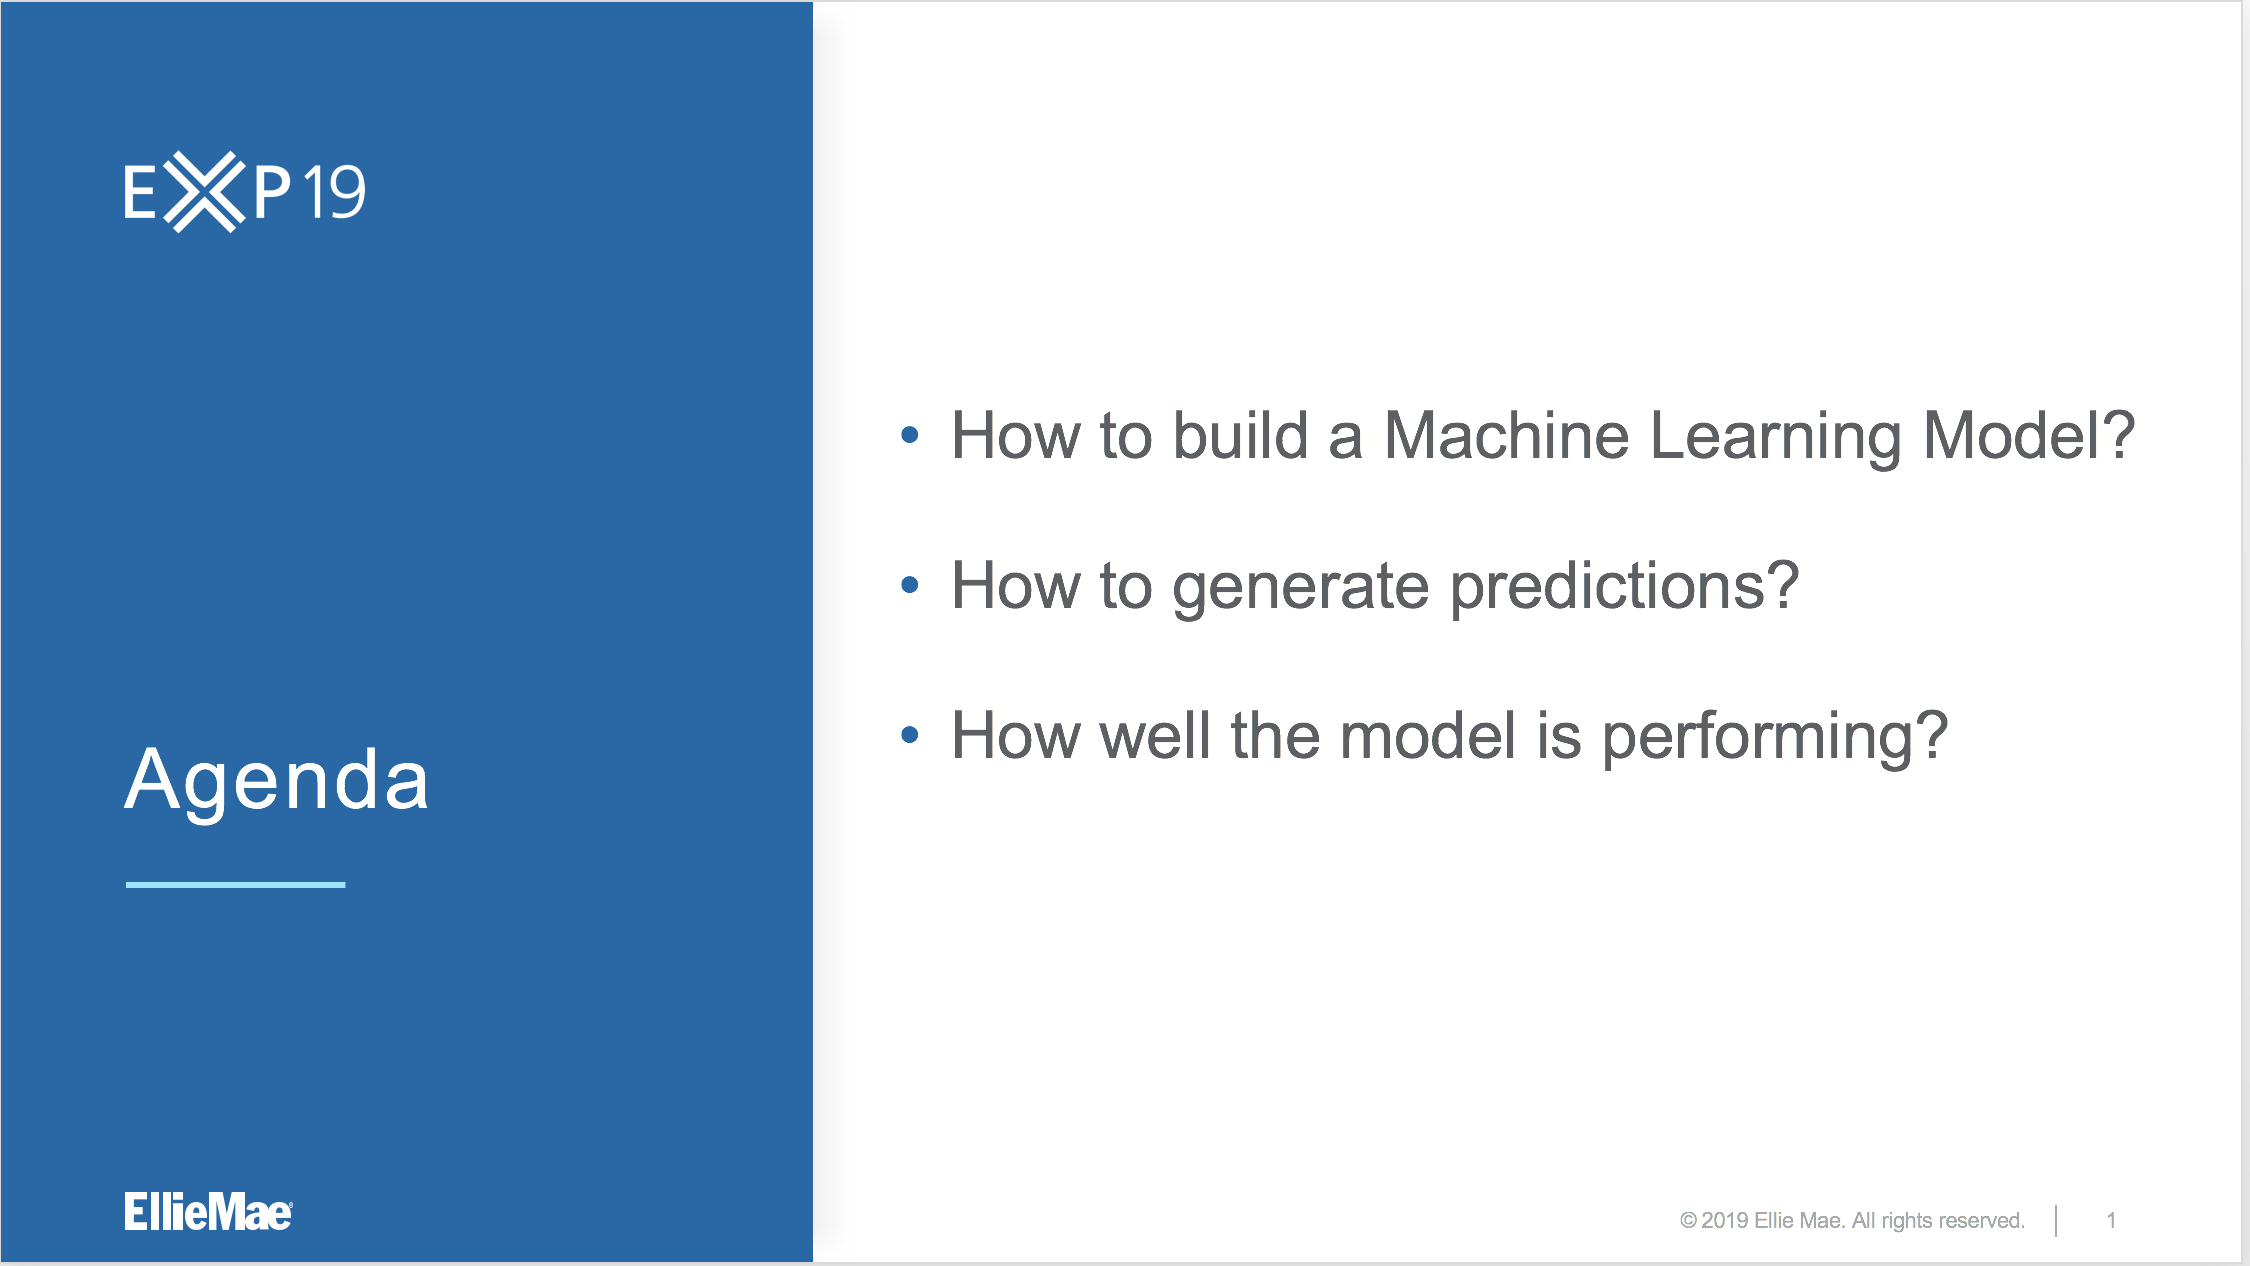

In [52]:
from IPython.display import Image
Image(filename='ModelAgenda.png', width=900, height=700)

# Modeling

## 1. Model training on dataset

#### Features  - FICO score, Income, Debt-To-Income ratio, Loan Amount, Loan Type, Loan Purpose, Term in Years, etc.
#### Outcome - Probability whether a loan application is going to be closed or not

### Benchmark Model - Logistic Regresssion

In [56]:
# Logistic Regression Classifier
logreg = linear_model.LogisticRegression(C=1e5)

# Fit training data
logreg.fit(X, Y);

print("Completed model training and generation")

Completed model training and generation


# 2. Predictions on test data set using the generated model

In [57]:
# Let's try the model on test dataset
test_y = logreg.predict(test.ix[:, test.columns != LABEL_COLUMN])
print("Completed test dataset predictions")

Completed test dataset predictions


# 3. Model performance

### a. Accuracy

In [58]:
correct = np.sum(test_y == test[LABEL_COLUMN].values)
print("Number of correct predictions: {}".format(correct))
print("Number of wrong predictions: {}".format(len(test) - correct))                 

Number of correct predictions: 10251
Number of wrong predictions: 4824


In [59]:
print('Accuracy is %.2f' %(np.sum(test_y == test[LABEL_COLUMN].values)*100/len(test)))

Accuracy is 68.00


#### Data is not perfectly balanced

In [60]:
### Class percentage
percent_closed_loans = round(100.0*len(test[test[LABEL_COLUMN]==1])/len(test), 2)
percent_not_closed = round(100.0 - percent_closed_loans, 2)
print("Number of Loans - Closed in the dataset: {}".format(len(test[test[LABEL_COLUMN]==1])))
print("Number of Loans - Not closed in the dataset: {}".format(len(test[test[LABEL_COLUMN]==0])))
print("")
print("Percentage of Loans - Closed in the dataset: {}".format(percent_closed_loans))
print("Percentage of Loans - Not closed in the dataset: {}".format(percent_not_closed))

Number of Loans - Closed in the dataset: 8019
Number of Loans - Not closed in the dataset: 7056

Percentage of Loans - Closed in the dataset: 53.19
Percentage of Loans - Not closed in the dataset: 46.81


### b. Confusion Matrix

[[3620 3436]
 [1388 6631]]


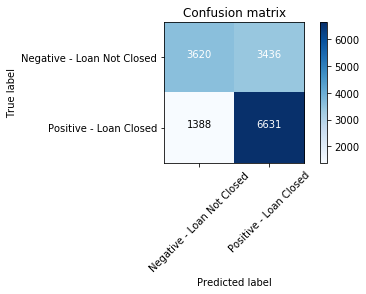

In [63]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(test[LABEL_COLUMN].values, test_y)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Negative - Loan Not Closed', 'Positive - Loan Closed'])

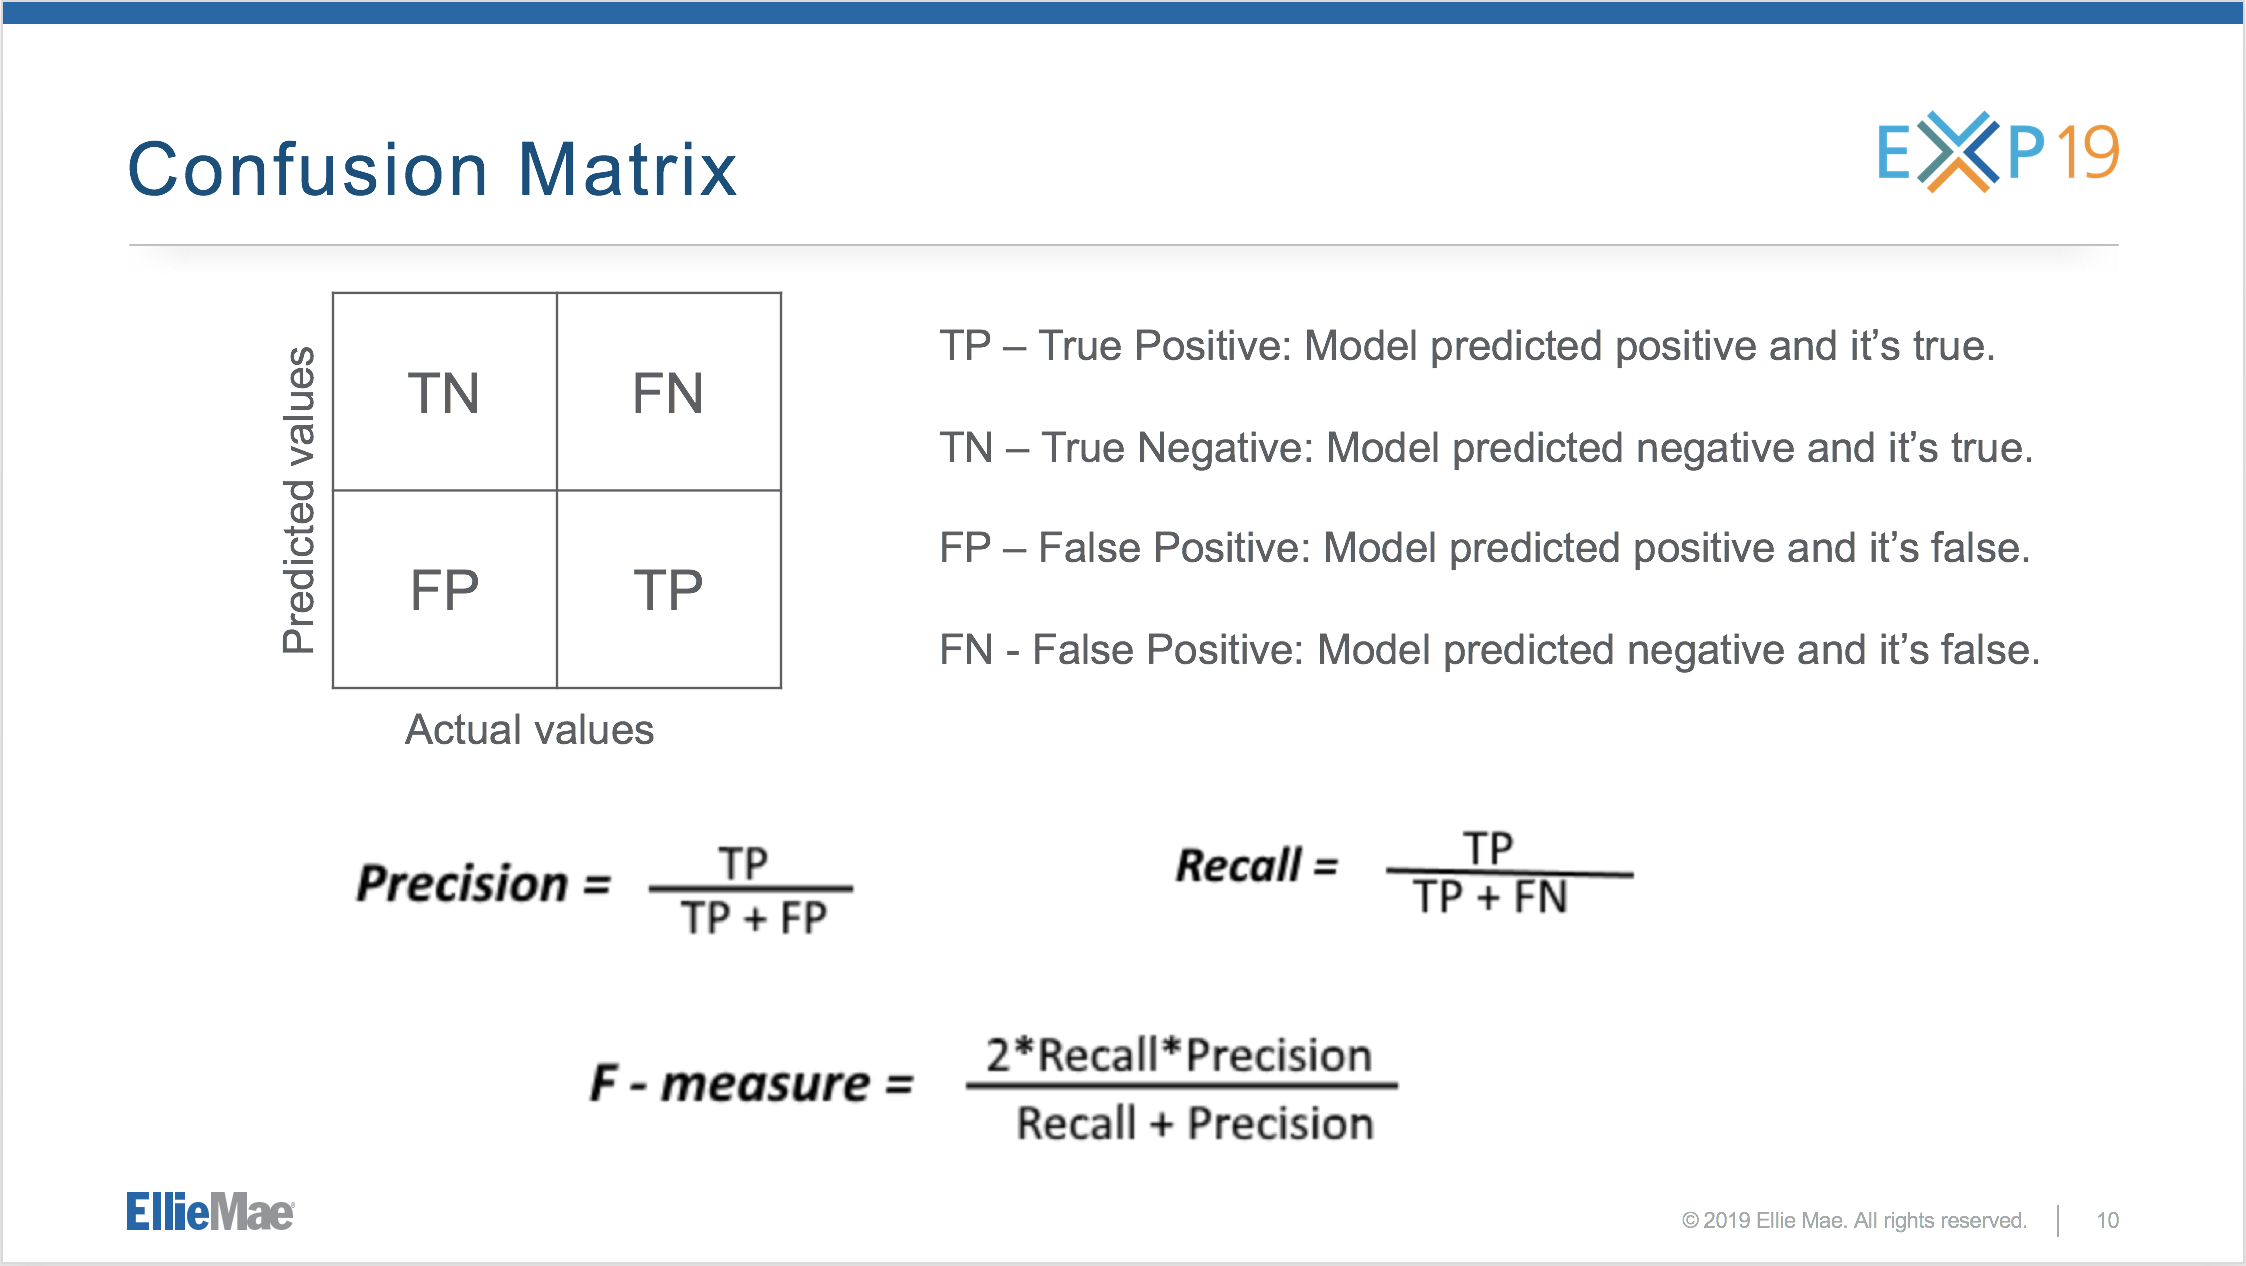

In [65]:
from IPython.display import Image
Image(filename='confusionmatrix.png', width=900, height=700)

### c. Precision, Recall and F-Score 

In [72]:

def F_beta(beta, p, r):
    return (1 + beta**2)*(p * r)/(beta**2 * p + r)

precision = precision_score(test[LABEL_COLUMN].values, test_y)
recall = recall_score(test[LABEL_COLUMN].values, test_y)

print('Precision is {:.2f}'.format(precision))
print('Recall is {:.2f}'.format(recall))
print('F-score is {:.2f}'.format(F_beta(0.5, precision, recall)))


Precision is 0.66
Recall is 0.83
F-score is 0.69


AUC is 0.72


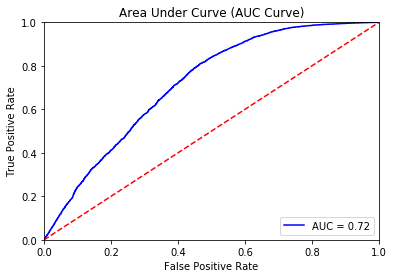

In [80]:
y_score = logreg.fit(X, Y).decision_function(test.ix[:, test.columns != LABEL_COLUMN])

fpr, tpr, _ = roc_curve(test[LABEL_COLUMN].ravel(), y_score.ravel())
roc_auc = auc(fpr, tpr)

print('AUC is %.2f' %roc_auc)

plt.title('Area Under Curve (AUC Curve)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### e. Let's try out a more advanced model

999

Model report: 
Accuracy: 89.75
AUC score (train): 0.960823


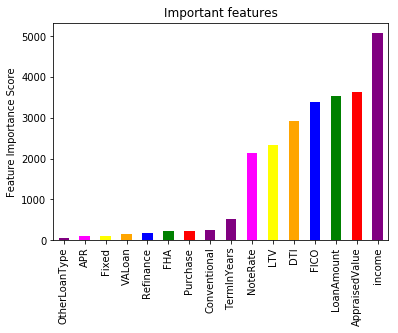

In [83]:
from xgboost.sklearn import XGBClassifier
import xgboost as xgb

predictors = ['LTV', 'FICO', 'DTI', 'LoanAmount', 'AppraisedValue', 'Fixed', 'APR', 'NoteRate', 'TermInYears',
             'income', 'Conventional', 'FHA', 'VALoan', 'OtherLoanType', 'Purchase', 'Refinance']

xgb_clf = XGBClassifier(learning_rate=0.1,
                       n_estimators=1000,
                       max_depth=5,
                       min_child_weight=1,
                       gamma=0,
                       subsample=0.8,
                       colsample_bytree=0.8,
                       objective='binary:logistic',
                       scale_pos_weight=1)

model = modelfit(xgb_clf, X, predictors, Y)


Model Report
Accuracy of the model: 83.97
AUC score: 0.913319
Matthews Correlation coefficient: 0.678626

Precision, Recall, F1beta, Support: 
(0.8410062895520292, 0.8397346600331675, 0.8390907489543932, None)
F1-score: 0.839091
[[5556 1500]
 [ 916 7103]]


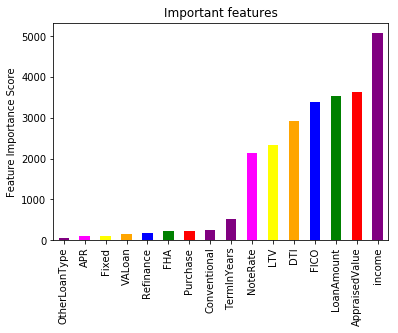

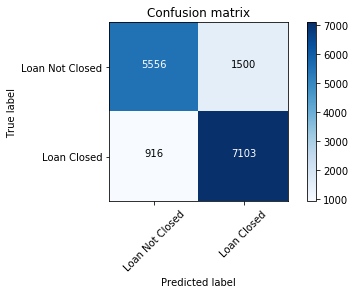

In [84]:
test_y = xgb_clf.predict(test[predictors])
test_probs = xgb_clf.predict_proba(test[predictors])[:,1]

print_model_metrics(test_y, test_probs, xgb_clf, test[LABEL_COLUMN].values, True)